In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import sklearn.metrics as metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score,roc_auc_score,recall_score,classification_report,mean_squared_error,accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [4]:
train=pd.read_csv("train_feature_engineered.csv")
test=pd.read_csv("test_feature_engineered.csv")

train.shape,test.shape

((18834, 19), (8072, 17))

In [23]:
train_set,val_set=train_test_split(train,test_size=.25,random_state=42)
train_set.shape,val_set.shape

#train_set
train_data=train_set.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed']
                          ,axis=1)
train_res_breed=train_set.breed_category
train_res_pet=train_set.pet_category

#val_set
val_data=val_set.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed'],
                     axis=1)
val_res_breed=val_set.breed_category
val_res_pet=val_set.pet_category
print(train_data.shape,train_res_breed.shape,train_res_pet.shape,val_data.shape,val_res_breed.shape,val_res_pet.shape)


train_full=train.drop(['pet_id', 'issue_date', 'listing_date','breed_category', 'pet_category','days_stayed']
                          ,axis=1)
train_full_breed=train.breed_category
train_full_pet=train.pet_category
test_full=test.drop(['pet_id', 'issue_date', 'listing_date','days_stayed']
                          ,axis=1)

train_full.shape,test_full.shape


(14125, 13) (14125,) (14125,) (4709, 13) (4709,) (4709,)


((18834, 13), (8072, 13))

In [8]:
lrc = LogisticRegression()
rfc=RandomForestClassifier()
adbc=AdaBoostClassifier()
bgc=BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bgcl_lrc = BaggingClassifier(base_estimator=lrc, random_state=42)
ab_rfc = AdaBoostClassifier(base_estimator=rfc,random_state=42)
ab_dtc = AdaBoostClassifier(base_estimator=dtc,random_state=42)
ab_nbc=  AdaBoostClassifier(base_estimator=gnb,random_state=42)
ab_lrc=  AdaBoostClassifier(base_estimator=lrc,random_state=42)
gbc=GradientBoostingClassifier()
ab_gbc=  AdaBoostClassifier(base_estimator=gbc,random_state=42)
xgbc=XGBClassifier()
ab_xgbc=  AdaBoostClassifier(base_estimator=xgbc,random_state=42)
lgbc=LGBMClassifier()
cat=CatBoostClassifier()

In [30]:
models=[rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,ab_rfc,ab_dtc,ab_nbc,ab_lrc,gbc,ab_gbc,xgbc,ab_xgbc,lgbc]
sctr,scte,ps,rs=[],[],[],[]
def ensemble_for_train_val(X_train,y_train,X_test, y_test):
    for model in models:
        print(model.__class__.__name__)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_pred_new=model.predict_proba(X_test)
        y_test_pred_new=y_test_pred_new[:,1]
        train_score=model.score(X_train,y_train)
        test_score=model.score(X_test,y_test)
        p_score=metrics.precision_score(y_test,y_test_pred,average='micro')
        r_score=metrics.recall_score(y_test,y_test_pred,average='micro')
        
#         ac=metrics.roc_auc_score(y_test,y_test_pred_new,multi_class="ovr",average='micro')
#         acc=accuracy_score(y_test,y_test_pred_new)
            
            
        sctr.append(train_score)
        scte.append(test_score)
        ps.append(p_score)
        rs.append(r_score)
#         auc.append(ac)
#         acc.append(acc)
    return sctr,scte,ps,rs




In [31]:
# checking the performance on train and validation
ensemble_for_train_val(train_data,train_res_breed, val_data, val_res_breed)
# 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
ensemble1=pd.DataFrame({'names':['Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR',"adaboost rf","adaboost dtc","adaboost naive bayes",
                                "adaboost logistic regression","gradient boosting trees"
                                ,"adaboost gbc","xgboost","adaboost xgbc","lgbm"],
                       'training':sctr,'testing':scte,'precision':ps,'recall':rs,})
ensemble1=ensemble1.sort_values(by='precision',ascending=False).reset_index(drop=True)
ensemble1

RandomForestClassifier
AdaBoostClassifier
BaggingClassifier
GaussianNB
KNeighborsClassifier
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
AdaBoostClassifier
AdaBoostClassifier
AdaBoostClassifier
GradientBoostingClassifier
AdaBoostClassifier
XGBClassifier
AdaBoostClassifier
LGBMClassifier


,names,training,testing,precision,recall
0,Bagging,0.995681,0.903377,0.903377,0.903377
1,xgboost,0.923965,0.902315,0.902315,0.902315
2,gradient boosting trees,0.927929,0.902102,0.902102,0.902102
3,lgbm,0.984425,0.900403,0.900403,0.900403
4,adaboost dtc,1.000000,0.899554,0.899554,0.899554
5,Decistion Tree,1.000000,0.899129,0.899129,0.899129
6,adaboost gbc,1.000000,0.898280,0.898280,0.898280
7,Random Forest,1.000000,0.896369,0.896369,0.896369
8,adaboost rf,1.000000,0.895307,0.895307,0.895307
9,Ada boost,0.889770,0.889786,0.889786,0.889786


In [27]:
# # checking the performance on train and validation
# models=[rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,ab_rfc,ab_dtc,ab_nbc]
# ensemble_for_train_val(train_data,train_res_breed, val_data, val_res_pet)
# # 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
# ensemble1=pd.DataFrame({'names':['Random Forest','Ada boost','Bagging',
#                                 'Naive-Bayes','KNN','Decistion Tree',
#                                 'bagged LR',"adaboost rf","adaboost dtc","adaboost naive bayes"
#                                 ],
#                        'training':sctr,'testing':scte,'precision':ps,'recall':rs,})
# ensemble=ensemble.sort_values(by='precision',ascending=False).reset_index(drop=True)
# ensemble

RandomForestClassifier
AdaBoostClassifier
BaggingClassifier
GaussianNB
KNeighborsClassifier
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
AdaBoostClassifier
AdaBoostClassifier


ValueError: arrays must all be same length

In [29]:
models=[lrc,rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,gbc,xgbc,lgbc]


def pred_on_full_data(Xtrain,ytrain,ytrain2,Xtest,models):
    for model in models:
        print(model.__class__.__name__)
        model.fit(Xtrain, ytrain)
        y_test_pred_breed = model.predict(Xtest)
        model.fit(Xtrain, ytrain2)
        y_test_pred2_pet=model.predict(Xtest)
        id=pd.Series(test["pet_id"])
        submission=pd.DataFrame({'pet_id':id,'breed_category':y_test_pred_breed,'pet_category':y_test_pred2_pet})
#         predictions=pd.concat([test['INCIDENT_ID'],pd.DataFrame(y_test_pred,columns=['MULTIPLE_OFFENSE'])],1)
        a="submission_multiple_"+model.__class__.__name__+"submission.csv"
        submission.to_csv(a,index=False)
        

#getting predictions on full data
pred_on_full_data(Xtrain=train_full,ytrain=train_full_breed,ytrain2=train_full_pet,Xtest=test_full,models=models)

LogisticRegression
RandomForestClassifier
AdaBoostClassifier
BaggingClassifier
GaussianNB
KNeighborsClassifier
DecisionTreeClassifier
BaggingClassifier
GradientBoostingClassifier
XGBClassifier
LGBMClassifier


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


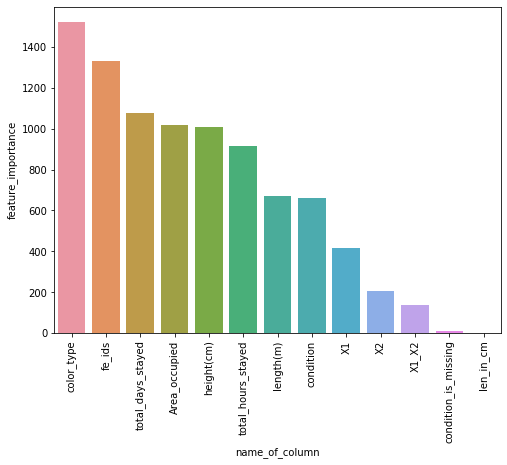

LGBMClassifier


In [37]:
def plot_graph(a):
    plt.figure(figsize=(8,6))
    chart=sns.barplot(x=a["name_of_column"],y=a["feature_importance"])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()
def feature_importance_plot_rev(dataframe,classifier,limit_of_the_importance):
    x=list(zip(dataframe.columns,classifier.feature_importances_))
    xx=pd.DataFrame(x)
    xx.columns=["name_of_column","feature_importance"]
    xx=xx.sort_values("feature_importance",ascending=False)
    xx=xx[xx["feature_importance"]>limit_of_the_importance]
    plot_graph(xx)
    return xx

models=[lgbc]
for model in models:
    print(model)
    feature_importance_plot_rev(train_full,model,-1000)
    
    print(model.__class__.__name__)